## MADlib Greenplum Demo
---

### Import neccessary Data Science libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
pd.set_option('display.max_columns', 200)

Connect to Greenplum Database

In [2]:
%load_ext sql

In [3]:
!minikube service list

|-------------|------------------------------------------------------|--------------|------------------------------|
|  NAMESPACE  |                         NAME                         | TARGET PORT  |             URL              |
|-------------|------------------------------------------------------|--------------|------------------------------|
| default     | agent                                                | No node port |
| default     | greenplum                                            | psql/5432    | http://192.168.133.128:32000 |
| default     | greenplum-validating-webhook-service-9d44d9fcf-t26tq | No node port |
| default     | kubernetes                                           | No node port |
| default     | my-greenplum-pl                                      | No node port |
| default     | my-greenplum-pxf                                     | No node port |
| kube-system | kube-dns                                             | No node port |
|-------------|-

In [4]:
%sql postgresql://gpadmin@192.168.133.128:32000/db

        
%sql SELECT version();

 * postgresql://gpadmin@192.168.133.128:32000/db
1 rows affected.


/usr/local/anaconda3/envs/madlib/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


version
"PostgreSQL 9.4.24 (Greenplum Database 6.11.2 build commit:d611e78af2c5a6561ccbbaf2b4652138410f9aeb) on x86_64-unknown-linux-gnu, compiled by gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0, 64-bit compiled on Sep 30 2020 05:25:08"


### Check Database Data

In [5]:
%%sql


SELECT COUNT(*) AS num_sample FROM sensors;

 * postgresql://gpadmin@192.168.133.128:32000/db
1 rows affected.


num_sample
200000


In [7]:
%%sql

SELECT * FROM sensors LIMIT 10;

 * postgresql://gpadmin@192.168.133.128:32000/db
10 rows affected.


timestamp,temperature,temperature_2,humidity,pm25
1997-03-22 00:00:00,30.6668585650253,42.9052858044298,69.2785492479998,73.1767528823951
1997-03-22 04:00:00,32.2240553161353,48.4451885030855,61.2088571248697,103.956207334568
1997-03-22 12:00:00,32.4185793403592,46.2930967363855,69.3046298170464,87.3012012853493
1997-03-22 20:00:00,31.6889779538602,50.3771697898689,53.2251690054103,76.757504341768
1997-03-22 21:00:00,31.414135143836,45.8292816079858,53.655786244688,77.837155684718
1997-03-22 22:00:00,31.5117735558417,49.7762550293786,31.5185341489772,98.0131261241892
1997-03-23 04:00:00,30.9732062825728,50.7305651158765,51.6463117699311,76.6613962119159
1997-03-23 06:00:00,31.1456715016839,50.5883567654865,50.6392021695488,77.1011145867884
1997-03-23 08:00:00,32.9173479628012,48.2255788669841,62.5489084902205,87.1120555127665
1997-03-23 12:00:00,32.5277304291036,47.7246721062276,15.1710744913787,91.5709933365243


In [8]:
sensors = %sql SELECT * FROM sensors LIMIT 1000;
sensors = sensors.DataFrame()

 * postgresql://gpadmin@192.168.133.128:32000/db
1000 rows affected.


In [9]:
sensors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   timestamp      1000 non-null   datetime64[ns]
 1   temperature    1000 non-null   float64       
 2   temperature_2  1000 non-null   float64       
 3   humidity       1000 non-null   float64       
 4   pm25           1000 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 39.2 KB


In [10]:
sensors.describe()

,temperature,temperature_2,humidity,pm25
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,31.546704,46.562115,49.825844,89.552287
std,0.872289,3.139024,14.967374,14.430473
min,30.002098,34.493309,1.160944,38.564782
25%,30.819098,44.387437,39.490404,79.670134
50%,31.576531,46.438833,50.040946,89.644032
75%,32.325675,48.665443,60.295111,99.163126
max,33.004882,55.152494,93.333323,132.791284


/usr/local/anaconda3/envs/madlib/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


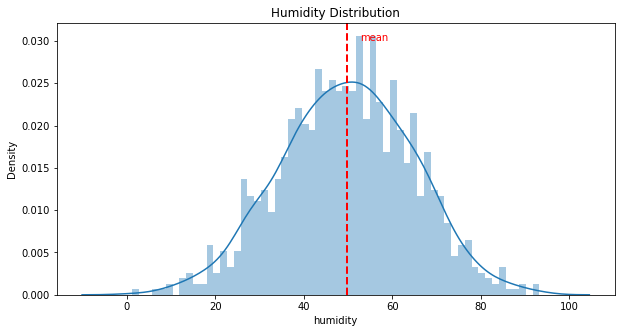

In [11]:
plt.figure(figsize=(10,5))
sns.distplot(sensors['humidity'],bins=60);
plt.title("Humidity Distribution")
plt.axvline(x=sensors['humidity'].mean(),color='red',ls='--',lw=2)
plt.text(sensors['humidity'].mean()+3,0.03, "mean", fontsize=10,c='red');

### EDA

In [12]:
%%sql
DROP TABLE IF EXISTS sensors_summary ;
SELECT madlib.summary (
    'sensors',  -- source_table
    'sensors_summary',  -- output_table
    NULL,  -- target_cols
    NULL,  -- grouping_cols
    TRUE,  -- get_distinct
    TRUE,  -- get_quartiles
    NULL,  -- quantile_array
    10,    -- how_many_mfv
    FALSE  -- get_estimate
);

SELECT * FROM sensors_summary LIMIT 5;

 * postgresql://gpadmin@192.168.133.128:32000/db
Done.
1 rows affected.
5 rows affected.


group_by,group_by_value,target_column,column_number,data_type,row_count,distinct_values,missing_values,blank_values,fraction_missing,fraction_blank,positive_values,negative_values,zero_values,mean,variance,confidence_interval,min,max,first_quartile,median,third_quartile,most_frequent_values,mfv_frequencies
None,None,"""timestamp""",1,timestamp,200000,200000,0,None,0.0,None,None,None,None,None,None,None,None,None,None,None,None,"['2019-07-25 11:00:00', '2019-12-01 19:00:00', '2019-11-03 16:00:00', '2019-11-23 21:00:00', '2019-11-26 21:00:00', '2019-12-21 14:00:00', '2020-01-03 09:00:00', '2019-11-30 16:00:00', '2019-12-15 03:00:00', '2019-11-05 15:00:00']","[202, 201, 197, 196, 196, 196, 196, 195, 194, 193]"
None,None,temperature,2,float8,200000,200000,0,None,0.0,None,200000,0,0,32.0007889310936,0.833918535707913,"[31.9967866933153, 32.0047911688719]",30.0020976922364,33.9932399275613,31.2506718159847,32.0007082471155,32.7509473341128,"['31.3932971558727', '31.1270586631445', '31.5795452103724', '31.3809975772738', '33.8450611683449', '31.0611840491863', '32.9212582895504', '33.8943804292179', '32.1098964308206', '31.1571707561875']","[204, 197, 196, 196, 195, 195, 195, 195, 195, 195]"
None,None,temperature_2,3,float8,200000,200000,0,None,0.0,None,200000,0,0,46.99570081252,9.80804681580791,"[46.9819751809047, 47.0094264441353]",32.2943907804811,61.6835823795163,44.8807517740374,46.9961843733011,49.112212070946,"['45.610033372541', '41.8933542334198', '48.7487345239526', '42.8628249997972', '51.7284036547247', '53.0636555990058', '49.144793481834', '42.5560303222563', '49.2545157623079', '53.5363445515196']","[200, 198, 198, 198, 198, 196, 196, 196, 196, 196]"
None,None,humidity,4,float8,200000,200000,0,None,0.0,None,199916,84,0,50.0315077284909,224.568211224632,"[49.9658304401699, 50.0971850168119]",-20.3266268501857,118.488627743178,39.9160404829,50.0412446801503,60.1484803615784,"['80.0789399962446', '58.9158137497979', '49.5808709283595', '40.8370079457451', '44.2457888796278', '81.0299847843547', '61.0819306716374', '71.5458767971577', '68.9138189296112', '57.5480243504294']","[200, 198, 198, 198, 197, 196, 194, 193, 193, 193]"
None,None,pm25,5,float8,200000,200000,0,None,0.0,None,200000,0,0,94.9567258520912,232.817325310956,"[94.8898531731814, 95.023598531001]",24.4732311088685,161.947176404423,84.6258824447947,94.9361338249605,105.200500570932,"['81.0193782019894', '113.419361265646', '111.01717457287', '86.2007469815971', '114.26224363525', '106.088352504439', '75.1810545024631', '115.516321815534', '68.4794225328913', '86.1884482285641']","[199, 198, 198, 198, 197, 196, 195, 195, 194, 194]"


In [13]:
%%sql

DROP TABLE IF EXISTS temp_sensors_timeseries;

CREATE TABLE temp_sensors_timeseries(
    year INTEGER,
    month INTEGER,
    average_month_temperature FLOAT,
    average_pm25 FLOAT
);

INSERT INTO temp_sensors_timeseries 
    SELECT  date_part('year', timestamp) AS year,
            date_part('month', timestamp) AS month,
            avg(temperature) AS average_month_temperature, 
            avg(pm25) AS average_pm25
    FROM sensors
    GROUP BY year, month;
    
    
SELECT * FROM temp_sensors_timeseries ORDER BY year,month LIMIT 20;

 * postgresql://gpadmin@192.168.133.128:32000/db
Done.
Done.
275 rows affected.
20 rows affected.


year,month,average_month_temperature,average_pm25
1997,3,31.5857867033122,89.6407995010372
1997,4,31.5333406560482,89.6954069445576
1997,5,31.5315084500734,88.9290781034526
1997,6,31.5087124676383,89.8276532672497
1997,7,31.4963020069132,89.946082918828
1997,8,31.5052959282945,89.8274028619428
1997,9,31.515806039429,89.6975457387193
1997,10,31.5212258387757,90.5202452816575
1997,11,31.5863566049458,90.7640554348525
1997,12,31.5260226914037,89.2248603940916


In [14]:
timeseries= %sql SELECT * FROM temp_sensors_timeseries ORDER BY year,month;
timeseries=timeseries.DataFrame()

 * postgresql://gpadmin@192.168.133.128:32000/db
275 rows affected.


In [15]:
timeseries['date']=pd.DatetimeIndex(timeseries['year'].map("{:04}".format)+'-'+ timeseries['month'].map("{:02}".format))
timeseries.head()

,year,month,average_month_temperature,average_pm25,date
0,1997,3,31.585787,89.640800,1997-03-01
1,1997,4,31.533341,89.695407,1997-04-01
2,1997,5,31.531508,88.929078,1997-05-01
3,1997,6,31.508712,89.827653,1997-06-01
4,1997,7,31.496302,89.946083,1997-07-01


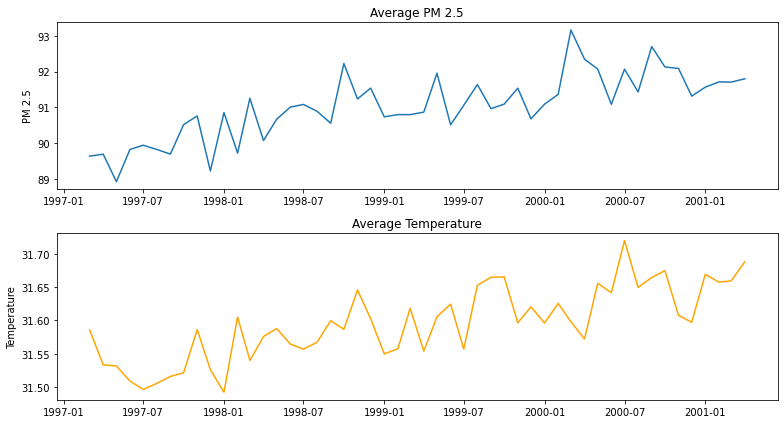

In [16]:
timeframe = 50

f, (ax1, ax2) = plt.subplots(2, 1,figsize=(11,6))
ax1.plot(timeseries['date'][:timeframe],timeseries['average_pm25'][:timeframe])
ax2.plot(timeseries['date'][:timeframe],timeseries['average_month_temperature'][:timeframe],color='orange')

ax1.yaxis.set_label_text("PM 2.5")
ax1.title.set_text('Average PM 2.5')

ax2.title.set_text('Average Temperature')
ax2.yaxis.set_label_text('Temperature')
plt.tight_layout()

### Preprocess Data

Encode Month

```sql
CREATE FUNCTION parse_month(time_stamp timestamp)
  RETURNS char
AS $$
  from datetime import datetime
  date_obj=datetime.strptime(time_stamp,"%Y-%m-%d %H:%M:%S")
  return date_obj.strftime("%B")
$$ LANGUAGE plpythonu;
```

In [17]:
%%sql
SELECT *,parse_month(timestamp) FROM sensors WHERE pm25 > 160;

 * postgresql://gpadmin@192.168.133.128:32000/db
2 rows affected.


timestamp,temperature,temperature_2,humidity,pm25,parse_month
2015-04-16 22:00:00,33.0799518195087,50.5450234515165,40.0489227220552,161.772615888742,April
2014-11-23 21:00:00,30.8058720843154,42.7842327160495,44.8122950799332,161.947176404423,November


Create Month and rain Data

In [18]:
%%sql
DROP TABLE IF EXISTS sensors_pre;
CREATE TABLE sensors_pre
AS 
SELECT
    timestamp,
    temperature,
    temperature_2,
    humidity,
    pm25,
    parse_month(timestamp) AS month,           --- Month data
    CASE WHEN
            (humidity )>= 60
        THEN 1
        ELSE 0
    END as rain
FROM sensors;

SELECT * FROM sensors_pre LIMIT 10; 

 * postgresql://gpadmin@192.168.133.128:32000/db
Done.
200000 rows affected.
10 rows affected.


timestamp,temperature,temperature_2,humidity,pm25,month,rain
1997-03-22 03:00:00,32.1011416309273,51.4144653929354,34.2725065145343,106.310825991151,March,0
1997-03-22 07:00:00,31.7222838010098,46.9562079315314,26.9962110043135,99.1593047202872,March,0
1997-03-23 02:00:00,31.3405572417669,45.8144550453893,45.2205060657009,97.1416891232006,March,0
1997-03-23 07:00:00,31.2215907980622,51.5581067009994,38.2136872440639,93.8665274880732,March,0
1997-03-23 13:00:00,32.0052114415293,44.4403435820022,36.5748920321032,114.375067434746,March,0
1997-03-24 01:00:00,31.2793714357319,47.2019846351074,65.0414598982477,98.5963393963257,March,1
1997-03-24 12:00:00,32.1177032017056,47.2922721171778,62.1540659560737,96.1068698089854,March,1
1997-03-24 16:00:00,32.4717679519442,45.5764088974802,89.4544707729493,91.5143249318502,March,1
1997-03-24 22:00:00,32.2748235034606,48.4546955302536,41.0963845240749,111.004351363702,March,0
1997-03-25 04:00:00,32.5561756957598,42.3400026333322,15.6706600932778,57.2378125792031,March,0


In [19]:
%%sql
SELECT parse_month(timestamp) as month ,COUNT(*) as count  
    FROM sensors  
GROUP BY month ORDER BY count DESC;

 * postgresql://gpadmin@192.168.133.128:32000/db
12 rows affected.


month,count
December,17112
May,17112
August,17112
July,17112
October,17112
January,16688
March,16608
November,16560
June,16560
April,16560


### Encode categorical values

In [20]:
%%sql
DROP TABLE IF EXISTS sensors_encoded;


SELECT
madlib.encode_categorical_variables (
    'sensors_pre',
    'sensors_encoded',
    'month',
    NULL,  --categorical_cols_to_exclude     -- Optional
    NULL,  --row_id,                         -- Optional
    NULL,  --top,                            -- Optional
    NULL,  --value_to_drop,                  -- Optional
    NULL,  --encode_null,                    -- Optional
    NULL,  --output_type,                    -- Optional
    NULL,  --output_dictionary,              -- Optional
    NULL   --distributed_by                  -- Optional
);


SELECT * FROM sensors_encoded LIMIT 5;

 * postgresql://gpadmin@192.168.133.128:32000/db
Done.
1 rows affected.
5 rows affected.


timestamp,temperature,temperature_2,humidity,pm25,rain,month_April,month_August,month_December,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September
1997-03-22 03:00:00,32.1011416309273,51.4144653929354,34.2725065145343,106.310825991151,0,0,0,0,0,0,0,0,1,0,0,0,0
1997-03-23 02:00:00,31.3405572417669,45.8144550453893,45.2205060657009,97.1416891232006,0,0,0,0,0,0,0,0,1,0,0,0,0
1997-03-23 07:00:00,31.2215907980622,51.5581067009994,38.2136872440639,93.8665274880732,0,0,0,0,0,0,0,0,1,0,0,0,0
1997-03-24 12:00:00,32.1177032017056,47.2922721171778,62.1540659560737,96.1068698089854,1,0,0,0,0,0,0,0,1,0,0,0,0
1997-03-25 04:00:00,32.5561756957598,42.3400026333322,15.6706600932778,57.2378125792031,0,0,0,0,0,0,0,0,1,0,0,0,0


### Correlation

In [21]:
%%sql
DROP TABLE IF EXISTS sensors_correlations;
DROP TABLE IF EXISTS sensors_correlations_summary;

SELECT 
madlib.correlation(
    'sensors_encoded', -- source_table
    'sensors_correlations',  -- target_table
    'temperature,temperature_2,humidity,pm25,rain',
    TRUE -- verbose
)

 * postgresql://gpadmin@192.168.133.128:32000/db
Done.
Done.
1 rows affected.


correlation
"Summary for 'Correlation' functionOutput table = sensors_correlationsProducing correlation for columns: temperature,temperature_2,humidity,pm25,rainTotal run time = ('sensors_correlations', 5, 4.2049431800842285)"


In [22]:
Index = %sql SELECT variable FROM sensors_correlations ORDER BY column_position;
Index = Index.DataFrame();

columns =  ','.join(','.join('%s' %x for x in y) for y in Index.values)
print(columns)

 * postgresql://gpadmin@192.168.133.128:32000/db
5 rows affected.
temperature,temperature_2,humidity,pm25,rain


In [23]:
corr = %sql select variable,{columns} from sensors_correlations ORDER BY column_position;
corr = corr.DataFrame()

 * postgresql://gpadmin@192.168.133.128:32000/db
5 rows affected.


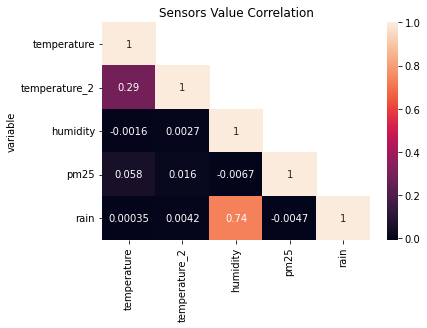

In [24]:
corr_df=corr.set_index('variable')
plt.title('Sensors Value Correlation')
sns.heatmap(corr_df,annot=True);

### Split Data for training and testing

In [25]:
%%sql
DROP TABLE IF EXISTS sensors_split CASCADE;
DROP TABLE IF EXISTS sensors_split_train CASCADE;
DROP TABLE IF EXISTS sensors_split_test CASCADE;

SELECT madlib.train_test_split(
    'sensors_encoded', -- source_table,
    'sensors_split', -- output_table,
    0.7, -- train_proportion,
    NULL, -- test_proportion,
    NULL, -- grouping_cols,
    'temperature,temperature_2,rain,humidity,pm25,
    "month_January","month_February","month_March",
    "month_April","month_May","month_June","month_July",
    "month_August","month_September","month_October",
    "month_November","month_December"', -- target_cols
    FALSE, -- with_replacement,
    TRUE -- separate_output_tables
);

SELECT COUNT(*) as "# In training set" FROM sensors_split_train;

 * postgresql://gpadmin@192.168.133.128:32000/db
Done.
Done.
Done.
1 rows affected.
1 rows affected.


# In training set
140000


In [26]:
%%sql
SELECT * FROM sensors_split_train LIMIT 5;

 * postgresql://gpadmin@192.168.133.128:32000/db
5 rows affected.


temperature,temperature_2,rain,humidity,pm25,month_January,month_February,month_March,month_April,month_May,month_June,month_July,month_August,month_September,month_October,month_November,month_December
30.0210832601055,42.9064464435664,1,63.093834148217,108.936448810382,0,0,0,1,0,0,0,0,0,0,0,0
30.021610288808,43.7499412344377,0,40.803713862809,105.490066388239,0,0,0,0,0,0,0,0,1,0,0,0
30.0233328496095,46.4828477143712,1,67.7743623717212,84.0648064261981,0,0,0,0,0,0,1,0,0,0,0,0
30.0357202348213,41.6970643463286,1,79.5710581773714,82.9018072245539,0,0,0,0,0,1,0,0,0,0,0,0
30.0363189224595,47.5791821834829,1,68.9829039558788,83.3623320632097,0,0,0,0,0,1,0,0,0,0,0,0


In [27]:
train_rain = %sql SELECT COUNT(*) FROM sensors_split_train WHERE rain = 1;
test_rain = %sql SELECT COUNT(*) FROM sensors_split_test WHERE rain = 1;

print("\nTotal rain in training set {}".format(train_rain[0][0]))
print("Total rain in testing set {}".format(test_rain[0][0]))

 * postgresql://gpadmin@192.168.133.128:32000/db
1 rows affected.
 * postgresql://gpadmin@192.168.133.128:32000/db
1 rows affected.

Total rain in training set 35466
Total rain in testing set 15149


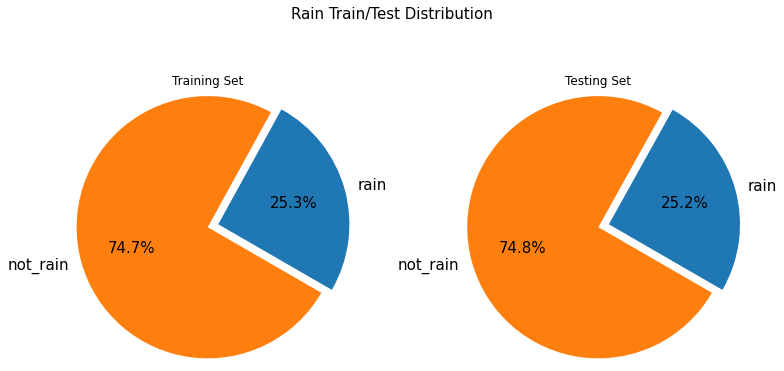

In [28]:
train_data=[train_rain[0][0],int((200000*0.7)-train_rain[0][0])]
test_data=[test_rain[0][0],int((200000*0.3)-test_rain[0][0])]

labels = ['rain','not_rain']

f, (ax1, ax2) = plt.subplots(1, 2,figsize=(11,6))
f.patch.set_facecolor('white')
ax1.title.set_text('Training Set')
ax2.title.set_text('Testing Set')
f.suptitle("Rain Train/Test Distribution",fontsize=15)
ax1.pie(train_data,labels=labels,autopct="%.1f%%",radius=1.2,textprops={'fontsize': 15,},explode = [0.1, 0],startangle = -30);
ax2.pie(test_data,labels=labels,autopct="%.1f%%",radius=1.2,textprops={'fontsize': 15},explode = [0.1, 0], startangle = -30);
plt.tight_layout()

## Logistic Regresion ( Classification model )

In [29]:
%%sql
DROP TABLE IF EXISTS sensors_logreg_model;
DROP TABLE IF EXISTS sensors_logreg_model_summary;

SELECT
    madlib.logregr_train(        -- Train the Logistic Regression Model
        'sensors_split_train',   -- source_table,
        'sensors_logreg_model',  -- out_table,
        'rain',                  -- labels,
        'ARRAY[
            1,
            temperature,
            temperature_2,
            humidity,pm25,
            "month_January","month_February","month_March",
            "month_April","month_May","month_June",
            "month_July","month_August","month_September",
            "month_October","month_November","month_December"]'       -- feature
        --, -- grouping_cols,
        --, -- max_iter,
        --, -- optimizer,
        --, -- tolerance,
        -- verbose
    )
;
SELECT * FROM sensors_logreg_model_summary ;           --- Get the summary table

 * postgresql://gpadmin@192.168.133.128:32000/db
Done.
Done.
1 rows affected.
1 rows affected.


method,source_table,out_table,dependent_varname,independent_varname,optimizer_params,num_all_groups,num_failed_groups,num_rows_processed,num_missing_rows_skipped,grouping_col
logregr,sensors_split_train,sensors_logreg_model,rain,"ARRAY[ 1, temperature, temperature_2, humidity,pm25, ""month_January"",""month_February"",""month_March"", ""month_April"",""month_May"",""month_June"", ""month_July"",""month_August"",""month_September"", ""month_October"",""month_November"",""month_December""]","optimizer=irls, max_iter=20, tolerance=0.0001",1,0,140000,0,None


In [30]:
logreg_coefs = %sql SELECT coef FROM sensors_logreg_model ;
logreg_coefs = logreg_coefs.DataFrame();

 * postgresql://gpadmin@192.168.133.128:32000/db
1 rows affected.


In [31]:
logreg_coef_names = (
    'intercept',
    'temperature',
    'temperature_2',
    'humidity',
    'pm25',
    "month_January","month_February","month_March",
    "month_April","month_May","month_June","month_July",
    "month_August","month_September","month_October",
    "month_November","month_December"
)
tuple(zip(logreg_coef_names, logreg_coefs.iloc[0, 0]))

(('intercept', -16036.3274172147),
 ('temperature', 0.0381577591603279),
 ('temperature_2', 0.0256436055535459),
 ('humidity', 289.539350988271),
 ('pm25', -0.0216654775896871),
 ('month_January', -1336.63798378595),
 ('month_February', -1336.77877256774),
 ('month_March', -1335.84187684721),
 ('month_April', -1336.85790718947),
 ('month_May', -1335.12198998131),
 ('month_June', -1335.51880185834),
 ('month_July', -1337.67173876969),
 ('month_August', -1336.03666938952),
 ('month_September', -1336.39739848611),
 ('month_October', -1335.61796867428),
 ('month_November', -1336.51021031199),
 ('month_December', -1337.33610394818))

In [32]:
%%sql
DROP TABLE IF EXISTS sensors_logreg_test_prob;
CREATE TABLE sensors_logreg_test_prob
AS
SELECT madlib.logregr_predict_prob(   --- Use the logistic regression model to estimate probability of mature
        coef, 
        ARRAY[
            1,
            temperature,
            temperature_2,
            humidity,
            pm25,
            "month_January","month_February","month_March",
            "month_April","month_May","month_June","month_July",
            "month_August","month_September","month_October",
            "month_November","month_December"]                   
    ) as pred,
    test.rain as y_test
FROM sensors_split_test test, sensors_logreg_model model;

SELECT * FROM sensors_logreg_test_prob LIMIT 10;

 * postgresql://gpadmin@192.168.133.128:32000/db
Done.
60000 rows affected.
10 rows affected.


pred,y_test
1.65424229576997e-294,0
0.0,0
0.0,0
0.0,0
0.0,0
0.0,0
0.0,0
0.0,0
0.0,0
0.0,0


### Confusion Matrix

In [33]:
%%sql
DROP TABLE IF EXISTS sensors_logreg_test_predict ;
CREATE TABLE sensors_logreg_test_predict
AS
SELECT
    (pred >= 0.5)::integer as pred,
    y_test
FROM sensors_logreg_test_prob;


SELECT * FROM sensors_logreg_test_predict LIMIT 10;

 * postgresql://gpadmin@192.168.133.128:32000/db
Done.
60000 rows affected.
10 rows affected.


pred,y_test
0,0
0,0
0,0
0,0
0,0
0,0
1,1
1,1
0,0
1,1


In [34]:
%%sql
DROP TABLE IF EXISTS sensors_logreg_test_conf_matrix;
SELECT
madlib.confusion_matrix(
    'sensors_logreg_test_predict',
    'sensors_logreg_test_conf_matrix',
    'pred',  -- prediction_col
    'y_test' -- observation_col
);

 * postgresql://gpadmin@192.168.133.128:32000/db
Done.
1 rows affected.


confusion_matrix
""


In [35]:
confusion = %sql SELECT \
                        confusion_arr[1] as "Predicted 0",\
                        confusion_arr[2] as "Predicted 1" \
                        FROM sensors_logreg_test_conf_matrix ORDER BY row_id;

confusion=confusion.DataFrame()

 * postgresql://gpadmin@192.168.133.128:32000/db
2 rows affected.


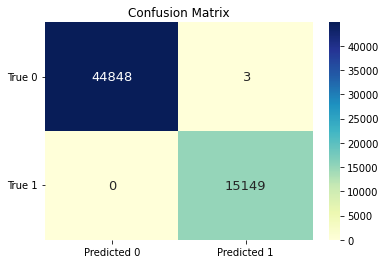

In [36]:
plt.title('Confusion Matrix')
sns.heatmap(confusion.astype(int),annot=True,cmap="YlGnBu",fmt='d',yticklabels=['True 0','True 1'],annot_kws={"fontsize":13});
plt.yticks(rotation=0);

In [50]:
y_test= %sql SELECT y_test FROM sensors_logreg_test_predict;
pred = %sql SELECT pred FROM sensors_logreg_test_predict;


print(classification_report(y_test,pred))

 * postgresql://gpadmin@192.168.133.128:32000/db
60000 rows affected.
 * postgresql://gpadmin@192.168.133.128:32000/db
60000 rows affected.
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     44851
           1       1.00      1.00      1.00     15149

    accuracy                           1.00     60000
   macro avg       1.00      1.00      1.00     60000
weighted avg       1.00      1.00      1.00     60000



### ROC

In [51]:
%%sql
DROP TABLE IF EXISTS sensors_logreg_test_auc;
SELECT
madlib.area_under_roc(
    'sensors_logreg_test_prob', 
    'sensors_logreg_test_auc', 
    'pred',  -- predictions, 
    'y_test'
);

SELECT * FROM sensors_logreg_test_auc;

 * postgresql://gpadmin@192.168.133.128:32000/db
Done.
1 rows affected.
1 rows affected.


area_under_roc
0.999999995584649763505967314035200811652051580


## Linear Regression  ( Regression Model )

In [38]:
%%sql
DROP TABLE IF EXISTS sensors_linreg_model;
DROP TABLE IF EXISTS sensors_linreg_model_summary;

SELECT madlib.linregr_train(
    'sensors_split_train',   -- source_table
    'sensors_linreg_model',  -- out_table
    'temperature_2',         -- labels
    'ARRAY[
        1,
        temperature,
        humidity,pm25,
        "month_January","month_February","month_March",
        "month_April","month_May","month_June",
        "month_July","month_August","month_September",
        "month_October","month_November","month_December"]',       -- feature
    NULL,  -- grouping_cols
    TRUE  -- heteroskedasticity_option
);

SELECT * FROM sensors_linreg_model LIMIT 10;

 * postgresql://gpadmin@192.168.133.128:32000/db
Done.
Done.
1 rows affected.
1 rows affected.


[([13.979089843992, 0.996377192058678, 0.00042600896385732, -0.000553530864677003, 1.16635917217237, 1.16496946281221, 1.20242891487683, 1.13423481062356, 1.17715455637042, 1.16952772652831, 1.1309915842705, 1.19004577324681, 1.13511463653315, 1.18663298465487, 1.15589942044383, 1.1657308012989], 0.0839661662759716, [0.263072733685494, 0.00880898783440294, 0.000535179003467631, 0.000527108205045474, 0.0344562268410434, 0.0355705311996003, 0.0345569615457121, 0.034 ... (22 characters truncated) ... 87929676055, 0.0343765208711318, 0.034331410931225, 0.0341786049183402, 0.034603025103017, 0.0343210981487332, 0.0345754824917438, 0.0343521585186793], [53.1377374163912, 113.109157463857, 0.79601210267414, -1.05012758173485, 33.8504612693991, 32.7509717601658, 34.7955624885091, 33.0041723802353, 34.4915379072375, 34.0211195575186, 32.9433470280666, 34.8184420075096, 32.8039133328312, 34.5744468755779, 33.4311869897938, 33.934717687828], [0.0, 0.0, 0.426026350777908, 0.293661272044726, 3.69517723179865e-250, 2.28030412112204e-234, 3.84974398849407e-264, 5.84852349806166e-238, 1.3320546 ... (24 characters truncated) ... 297456e-252, 4.28711407801691e-237, 1.74686334804624e-264, 4.06828441058346e-235, 7.77261162264678e-261, 4.46144077806461e-244, 2.16999937365974e-251], 10958716156.1084, 17.5845018682443, 0.285138837986759, 140000, 0, [[0.0692072632087589, -0.00226990385313545, -1.35020275621036e-05, -1.68417698266217e-05, 0.00577173550859092, 0.00575759349360408, 0.0057951979535454 ... (5370 characters truncated) ... .000417370165952408, 0.00042459989069746, 0.000420372252566258, 0.000423113952367227, 0.00042525492684192, 0.000421594225003185, 0.00118007079489247]])]

In [39]:
%%sql
DROP TABLE IF EXISTS sensors_linreg_test_predict;

CREATE TABLE sensors_linreg_test_predict
AS
SELECT 
    madlib.linregr_predict(
        coef, 
        ARRAY[
            1,
            temperature,
            humidity,pm25,
            "month_January","month_February","month_March",
            "month_April","month_May","month_June",
            "month_July","month_August","month_September",
            "month_October","month_November","month_December"
            ] 
    ) as prediction,
    test.temperature_2 as y_test
FROM sensors_split_test test, sensors_linreg_model model;

SELECT * FROM sensors_linreg_test_predict LIMIT 5;

 * postgresql://gpadmin@192.168.133.128:32000/db
Done.
60000 rows affected.
5 rows affected.


prediction,y_test
47.9038533480603,47.1212313301289
48.0498835521669,45.2208094122754
45.636960391493,47.0720438025179
46.3212394709099,51.4727771391969
48.1680464875907,46.0193674588016


In [40]:
%%sql
DROP TABLE IF EXISTS sensors_linreg_test_predict_mse;

SELECT madlib.mean_squared_error(
    'sensors_linreg_test_predict',      -- table_in
    'sensors_linreg_test_predict_mse',  -- table_out
    'prediction',  -- prediction
    'y_test'  -- y_test
);

SELECT * FROM sensors_linreg_test_predict_mse;

 * postgresql://gpadmin@192.168.133.128:32000/db
Done.
1 rows affected.
1 rows affected.


mean_squared_error
8.91759263909133


In [51]:
pred = %sql SELECT * FROM sensors_linreg_test_predict LIMIT 200;
pred=pred.DataFrame()

 * postgresql://gpadmin@192.168.133.128:32000/db
200 rows affected.


In [52]:
pred

,prediction,y_test
0,46.546081,44.848916
1,46.799292,49.151719
2,48.259909,44.402924
3,47.198964,49.217530
4,48.421087,47.169735
...,...,...
195,46.909311,50.734306
196,45.311511,42.757229
197,47.799929,46.968943
198,45.402255,43.953387


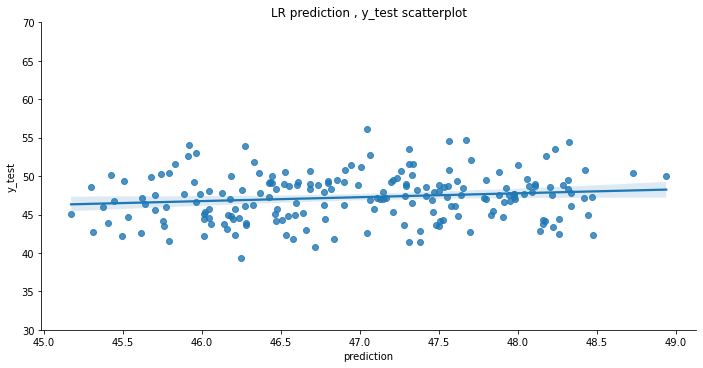

In [53]:
sns.lmplot(x='prediction',y='y_test',data=pred,height=5,aspect=2)
plt.title("LR prediction , y_test scatterplot") 
plt.ylim(30,70);

## Multilayer Perceptron ( ANN )

In [6]:
%%sql
DROP TABLE IF EXISTS sensors_mlp_model;
DROP TABLE IF EXISTS sensors_mlp_model_standardization;

SELECT madlib.mlp_regression(
    'sensors_split_train',           -- source_table
    'sensors_mlp_model',             -- out_table
    'ARRAY[
        1,
        temperature,
        humidity,pm25,
        "month_January","month_February","month_March",
        "month_April","month_May","month_June",
        "month_July","month_August","month_September",
        "month_October","month_November","month_December"]',       -- feature
    'temperature_2',                 -- labels
    ARRAY[16],                       -- hidden_layer_sizes
    NULL,                            -- optimizer_params,
    NULL,                            -- activation,
    NULL,                            -- weights,
    NULL,                            -- warm_start,
    NULL,                            -- verbose,
    NULL                             -- grouping_col
);

SELECT * FROM sensors_mlp_model;

 * postgresql://gpadmin@192.168.133.128:32000/db
Done.
Done.
1 rows affected.
1 rows affected.


[([-4.3099405511984, -0.0106923452097438, 1.08808474559252, -0.43668527866001, 0.192465418011589, 0.0017363990330704, 0.0208205760995734, -0.31255564453 ... (5434 characters truncated) ... 205, -0.0566460547975288, 4.46761421070877, 3.98943172073901, 0.404179059791326, 0.416116776611396, 4.0541999106364, 3.25465005519226, 0.791662931651], 5.17818825458484, 43)]

Mean and Standard Deviation for normalizing inputs

In [7]:
%%sql

SELECT * FROM sensors_mlp_model_standardization;

 * postgresql://gpadmin@192.168.133.128:32000/db
1 rows affected.


mean,std
"[1.0, 32.001657988091, 50.0177690242888, 94.955559910521, 0.0835857142857143, 0.0742785714285714, 0.0831928571428571, 0.0833642857142857, 0.0856285714285714, 0.0832357142857143, 0.0851571428571429, 0.0853928571428571, 0.0827785714285714, 0.0853857142857143, 0.0826642857142857, 0.0853357142857143]","[1.0, 0.912058877188945, 14.9885198309731, 15.2419929875617, 0.276765501197424, 0.262223693161205, 0.276173506447062, 0.276432055995018, 0.279814794433163, 0.276238176494599, 0.279115395271474, 0.279465413051126, 0.275547236496424, 0.279454815813993, 0.275374112039663, 0.279380618785665]"


In [37]:
%%sql
SELECT 
    madlib.mlp_predict(
        'sensors_mlp_model',
        'sensors_split_test',
        'ARRAY[
            1,
            temperature,
            humidity,pm25,
            "month_January","month_February","month_March",
            "month_April","month_May","month_June",
            "month_July","month_August","month_September",
            "month_October","month_November","month_December"]',
        'sensors_mlp_test_predict',
        'response'
    );

 * postgresql://gpadmin@192.168.133.128:32000/db
1 rows affected.


mlp_predict
""


In [40]:
%%sql
DROP TABLE IF EXISTS sensors_mlp_test_predict;

SELECT 
    madlib.mlp_predict(
        'sensors_mlp_model',
        'sensors_split_test',
        'temperature_2',
        'sensors_mlp_test_predict',
        'response'
    );
    
SELECT * FROM sensors_mlp_test_predict LIMIT 5;

 * postgresql://gpadmin@192.168.133.128:32000/db
Done.
1 rows affected.
5 rows affected.


temperature_2,estimated_temperature_2
46.5399540766665,48.238485232197
47.0354463554396,47.8690245146145
40.627765240898,47.6570957367455
46.9201999244719,48.1715674350284
45.4997047385975,47.9030554722877


In [47]:
%%sql 
DROP TABLE IF EXISTS sensors_mlp_test_predict_mse;

SELECT madlib.mean_squared_error(
    'sensors_mlp_test_predict',      -- table_in
    'sensors_mlp_test_predict_mse',  -- table_out
    'estimated_temperature_2',  -- prediction
    'temperature_2'  -- y_test
);

SELECT * FROM sensors_mlp_test_predict_mse;

 * postgresql://gpadmin@192.168.133.128:32000/db
Done.
1 rows affected.
1 rows affected.


mean_squared_error
10.2874593157227


In [48]:
pred = %sql SELECT temperature_2 as y_test, estimated_temperature_2 as prediction FROM sensors_mlp_test_predict LIMIT 200;
pred=pred.DataFrame()

 * postgresql://gpadmin@192.168.133.128:32000/db
200 rows affected.


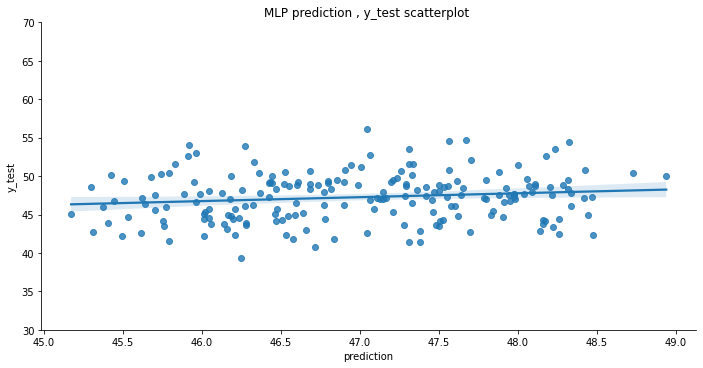

In [54]:
sns.lmplot(x='prediction',y='y_test',data=pred,height=5,aspect=2)
plt.title("MLP prediction , y_test scatterplot ") 
plt.ylim(30,70);